In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
def normalize_image(image: Image.Image) -> Image.Image:
    """
    Normalize the image to the range 0-255.
    :param image: The image to normalize.
    :return: A normalized image.
    """
    np_image = np.array(image)
    min_val = np.min(np_image)
    max_val = np.max(np_image)

    # Normalize to 0-255
    normalized_image = ((np_image - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    return Image.fromarray(normalized_image)

In [3]:
# Function to load images and masks
def load_images_and_masks(ct_images_path, masks_path, img_size=(256, 256)):
    ct_images = []
    masks = []
    limit = -1

    count = 0
    # Load and normalize CT images from all subdirectories
    for img_path in sorted(glob.glob(os.path.join(ct_images_path, '**', '*.png'), recursive=True)):
        if count == limit:
          break
        print(f"Loading image: {img_path}")  # Debug print
        img = Image.open(img_path)
        img = img.resize(img_size)
        normalized_image = normalize_image(img)
        ct_images.append(np.array(normalized_image))
        count += 1

    # Debug print to check the number of CT images loaded
    print(f"Loaded {len(ct_images)} CT images")
    count = 0
    # Load and resize corresponding masks from all subdirectories
    for mask_path in sorted(glob.glob(os.path.join(masks_path, '**', '*.png'), recursive=True)):
        if count == limit:
          break
        print(f"Loading mask: {mask_path}")  # Debug print
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
        mask = img_to_array(mask)
        mask = mask / 255.0  # Normalize the mask (binary)
        masks.append(mask)
        count += 1

    # Debug print to check the number of masks loaded
    print(f"Loaded {len(masks)} masks")

    return np.array(ct_images[:]), np.array(masks[:])

In [4]:
# Function to display a grid of images and masks
def display_grid(images, masks, nrows=1, ncols=2):
    plt.figure(figsize=(10, 5))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        if i % 2 == 0:
            plt.imshow(images[i // 2], cmap='gray', vmin=0, vmax=255)
            plt.title(f"Image {i // 2 + 1}")
        else:
            plt.imshow(masks[i // 2].squeeze(), cmap='gray', vmin=0, vmax=1)
            plt.title(f"Mask {i // 2 + 1}")
        plt.axis('off')
    plt.show()

In [5]:
# Define the Dice coefficient metric
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Define the Dice loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Define the combined loss function
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

Loading image: /mnt/d/Updated_Dataset/Images/P1/adb-p1-img-366.png
Loading image: /mnt/d/Updated_Dataset/Images/P1/adb-p1-img-370.png
Loading image: /mnt/d/Updated_Dataset/Images/P1/adb-p1-img-418.png
Loading image: /mnt/d/Updated_Dataset/Images/P10/ABD_LYMPH_IMG_309.png
Loading image: /mnt/d/Updated_Dataset/Images/P10/ABD_LYMPH_IMG_315.png
Loading image: /mnt/d/Updated_Dataset/Images/P10/ABD_LYMPH_IMG_343.png
Loading image: /mnt/d/Updated_Dataset/Images/P10/ABD_LYMPH_IMG_355.png
Loading image: /mnt/d/Updated_Dataset/Images/P11/ABD_LYMPH_IMG_149.png
Loading image: /mnt/d/Updated_Dataset/Images/P11/ABD_LYMPH_IMG_267.png
Loading image: /mnt/d/Updated_Dataset/Images/P11/ABD_LYMPH_IMG_310.png
Loading image: /mnt/d/Updated_Dataset/Images/P11/ABD_LYMPH_IMG_321.png
Loading image: /mnt/d/Updated_Dataset/Images/P11/ABD_LYMPH_IMG_409.png
Loading image: /mnt/d/Updated_Dataset/Images/P11/ABD_LYMPH_IMG_461.png
Loading image: /mnt/d/Updated_Dataset/Images/P12/ABD_LYMPH_IMG_371.png
Loading image: /mn

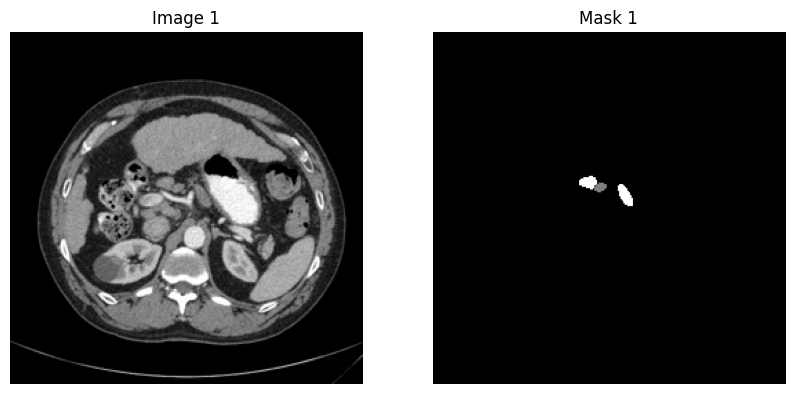

In [6]:
ct_images_path = r'/mnt/d/Updated_Dataset/Images'
masks_path = r'/mnt/d/Updated_Dataset/Masks'

# Example usage
ct_images, masks = load_images_and_masks(ct_images_path, masks_path)

# Display the first normalized image and its mask
if ct_images.any() and masks.any():
    display_grid(ct_images[:1], masks[:1])

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(ct_images[:], masks[:], test_size=0.2, random_state=42)

In [9]:
def conv_block(input_tensor, filters, dropout=False):
    x = Conv2D(filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Contracting path
    c1 = conv_block(inputs, 32)
    m1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(m1, 64)
    m2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(m2, 128)
    m3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(m3, 256)
    m4 = MaxPooling2D((2, 2))(c4)

    # Center block
    center = conv_block(m4, 512, dropout=True)

    # Expansion path
    u4 = UpSampling2D((2, 2))(center)
    sc4 = Concatenate()([u4, c4])
    c4_ep = conv_block(sc4, 256)

    u3 = UpSampling2D((2, 2))(c4_ep)
    sc3 = Concatenate()([u3, c3])
    c3_ep = conv_block(sc3, 128)

    u2 = UpSampling2D((2, 2))(c3_ep)
    sc2 = Concatenate()([u2, c2])
    c2_ep = conv_block(sc2, 64)

    u1 = UpSampling2D((2, 2))(c2_ep)
    sc1 = Concatenate()([u1, c1])
    c1_ep = conv_block(sc1, 32)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c1_ep)

    model = Model(inputs, outputs)
    return model

# Instantiate the model
model = unet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_18[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_23[0][0] 

 Total params: 7,857,857 (29.98 MB)

 Trainable params: 7,851,969 (29.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# # Attention UNet

# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Add, Multiply, Activation, Dropout, Input
# from tensorflow.keras.models import Model

# # Convolution Block (CB)
# def conv_block(x, filters):
#     x = Conv2D(filters, (3, 3), padding="same")(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(filters, (3, 3), padding="same")(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     return x

# # Center Block
# def center_block(x, filters):
#     x = Conv2D(filters, (3, 3), padding="same")(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Dropout(0.5)(x)
#     x = Conv2D(filters, (3, 3), padding="same")(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     return x

# # Attention Block (AB)
# def attention_block(g, x, filters):
#     # g path
#     g1 = Conv2D(filters, (1, 1), padding="same")(g)
#     g1 = BatchNormalization()(g1)

#     # x path
#     x1 = Conv2D(filters, (1, 1), padding="same")(x)
#     x1 = BatchNormalization()(x1)

#     # Combining and applying activation
#     combined = Add()([g1, x1])
#     combined = ReLU()(combined)
#     combined = Conv2D(1, (1, 1), padding="same")(combined)
#     combined = BatchNormalization()(combined)
#     combined = Activation('sigmoid')(combined)

#     # Attention mechanism
#     attention = Multiply()([x, combined])
#     return Concatenate()([attention, g])

# # U-Net with Attention
# def attention_unet(input_shape=(256, 256, 1)):
#     inputs = Input(input_shape)

#     # Encoder Path
#     c1 = conv_block(inputs, 32)
#     m1 = MaxPooling2D((2, 2))(c1)

#     c2 = conv_block(m1, 64)
#     m2 = MaxPooling2D((2, 2))(c2)

#     c3 = conv_block(m2, 128)
#     m3 = MaxPooling2D((2, 2))(c3)

#     c4 = conv_block(m3, 256)
#     m4 = MaxPooling2D((2, 2))(c4)

#     # Center Block
#     center = center_block(m4, 512)

#     # Decoder Path with Attention
#     u4 = UpSampling2D((2, 2))(center)
#     a4 = attention_block(u4, c4, 256)
#     c4_exp = conv_block(a4, 256)

#     u3 = UpSampling2D((2, 2))(c4_exp)
#     a3 = attention_block(u3, c3, 128)
#     c3_exp = conv_block(a3, 128)

#     u2 = UpSampling2D((2, 2))(c3_exp)
#     a2 = attention_block(u2, c2, 64)
#     c2_exp = conv_block(a2, 64)

#     u1 = UpSampling2D((2, 2))(c2_exp)
#     a1 = attention_block(u1, c1, 32)
#     c1_exp = conv_block(a1, 32)

#     # Output Layer
#     outputs = Conv2D(1, (1, 1), activation="sigmoid")(c1_exp)

#     # Model
#     model = Model(inputs, outputs)
#     return model

# # Instantiate the model
# model = attention_unet()
# model.summary()


In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model

# # Helper Functions for Capsule Layers
# class PrimaryCaps(layers.Layer):
#       def __init__(self, out_channels, kernel_size, strides, num_caps):
#           super(PrimaryCaps, self).__init__()
#           self.conv = layers.Conv2D(out_channels * num_caps, kernel_size, strides=strides, padding='valid')
#           self.num_caps = num_caps

#       @tf.function
#       def call(self, inputs):
#           out = self.conv(inputs)
#           batch_size, height, width, channels = tf.shape(out)
#           out = tf.reshape(out, (batch_size, height, width, self.num_caps, -1))
#           return self.squash(out)

#       @staticmethod
#       def squash(tensor):
#           norm = tf.norm(tensor, axis=-1, keepdims=True)
#           return (tensor / (1.0 + norm**2)) * norm

# class CapsuleLayer(layers.Layer):
#     def __init__(self, out_caps, kernel_size, strides, routing_iters):
#         super(CapsuleLayer, self).__init__()
#         self.conv = layers.Conv3D(out_caps, kernel_size, strides=strides, padding='valid')
#         self.routing_iters = routing_iters

#     def call(self, inputs):
#       x = self.conv(inputs)
#       batch_size, height, width, out_caps, channels = tf.shape(x)
#       x = tf.reshape(x, (batch_size, -1, out_caps, channels))

#       # Initialize routing weights (b_ij)
#       b_ij = tf.zeros((batch_size, tf.shape(x)[1], out_caps, 1), dtype=tf.float32)

#       for i in range(self.routing_iters):
#           # Calculate coupling coefficients (c_ij)
#           c_ij = tf.nn.softmax(b_ij, axis=2)

#           # Calculate weighted sum of inputs (s_j)
#           s_j = tf.reduce_sum(c_ij * x, axis=1, keepdims=True)

#           # Squash activation (v_j)
#           v_j = self.squash(s_j)

#           # Update routing weights (b_ij)
#           if i < self.routing_iters - 1:
#               b_ij += tf.reduce_sum(x * v_j, axis=-1, keepdims=True)

#       # The output is the squashed activation of the final iteration
#       v_j = tf.squeeze(v_j, axis=1)
#       return v_j

#     @staticmethod
#     def squash(tensor):
#         norm = tf.norm(tensor, axis=-1, keepdims=True)
#         return (tensor / (1.0 + norm**2)) * norm

# # SegCaps Network Architecture
# class SegCaps(Model):
#     def __init__(self):
#         super(SegCaps, self).__init__()
#         # Encoder
#         self.conv1 = layers.Conv2D(16, kernel_size=5, strides=1, padding='same', activation='relu')
#         self.primary_caps = PrimaryCaps(16, kernel_size=5, strides=2, num_caps=2)
#         self.caps_layer1 = CapsuleLayer(4, kernel_size=5, strides=2, routing_iters=3)
#         self.caps_layer2 = CapsuleLayer(8, kernel_size=5, strides=2, routing_iters=3)

#         # Decoder
#         self.deconv_caps1 = CapsuleLayer(4, kernel_size=4, strides=2, routing_iters=3)
#         self.deconv_caps2 = CapsuleLayer(2, kernel_size=4, strides=2, routing_iters=3)
#         self.output_caps = CapsuleLayer(1, kernel_size=1, strides=1, routing_iters=3)

#         # Reconstruction
#         self.reconstruction = tf.keras.Sequential([
#             layers.Conv2D(128, kernel_size=1, activation='relu', input_shape=(256, 256, 1)), # Update input_shape here
#             layers.Conv2D(1, kernel_size=1, activation='sigmoid')
#         ])

#     def call(self, inputs):
#         # Encoder
#         x = self.conv1(inputs)
#         x = self.primary_caps(x)
#         x = self.caps_layer1(x)
#         x = self.caps_layer2(x)

#         # Decoder
#         x = self.deconv_caps1(x)
#         x = self.deconv_caps2(x)
#         x = self.output_caps(x)

#         # Reconstruction
#         recon = self.reconstruction(x)
#         return x, recon

# model = SegCaps()
# model.summary()

In [10]:
# Reshape x_train and x_test to add a channel dimension | for SegCaps only
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [12]:
x_train.shape, x_test.shape

((271, 256, 256, 1), (68, 256, 256, 1))

In [13]:
# Convert x_train and x_test to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [14]:
# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

In [15]:
x_train[0].min(), x_train[0].max()

(np.float32(0.0), np.float32(1.0))

In [16]:
# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])

In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("white_model.keras", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [19]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/100


I0000 00:00:1742030416.080297   11930 service.cc:152] XLA service 0x7ff6d0003920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742030416.081003   11930 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-15 09:20:16.460119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742030417.727153   11930 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742030459.926450   11930 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - dice_coefficient: 0.0038 - loss: 1.6128 - val_dice_coefficient: 0.0041 - val_loss: 10.2758
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - dice_coefficient: 0.0039 - loss: 1.2592 - val_dice_coefficient: 0.0031 - val_loss: 8.0858
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - dice_coefficient: 0.0035 - loss: 1.1917 - val_dice_coefficient: 0.0037 - val_loss: 2.8705
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - dice_coefficient: 0.0041 - loss: 1.1578 - val_dice_coefficient: 0.0039 - val_loss: 2.2706
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - dice_coefficient: 0.0041 - loss: 1.1396 - val_dice_coefficient: 0.0041 - val_loss: 4.1463
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - dice_coefficient: 0.0047 - loss: 1.1261 - val_dice_coefficient: 0.0041 - val_loss: 1.9765
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - dice_coefficient: 0.0047 - loss: 1.1154 - val_dice_coefficient: 0.0042 - val_loss: 1.7690
Epoch 8/100


In [ ]:
# Save the model in .keras format
model.save('/content/drive/MyDrive/my_unet_model_3.keras')

In [ ]:
# Finding the performance of the model
# Evaluate the model on the test set
loss, dice_score = model.evaluate(x_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Dice Coefficient: {dice_score:.4f}")

Test Loss: 0.2028
Test Dice Coefficient: 0.8007


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


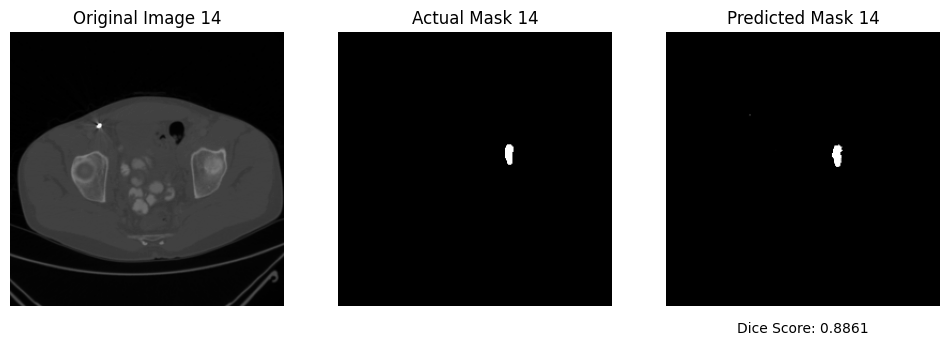

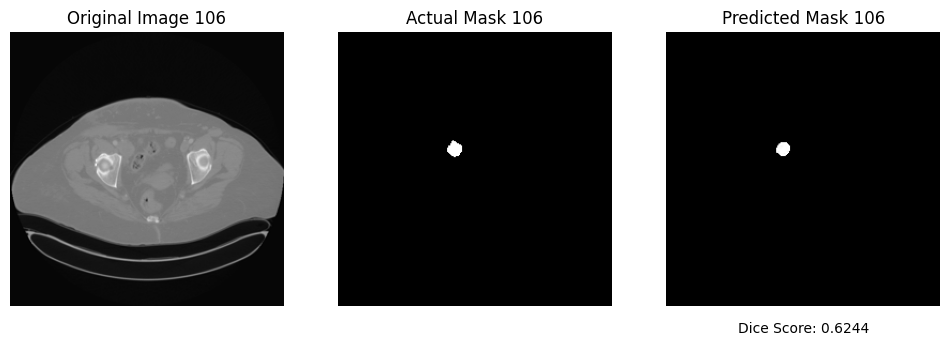

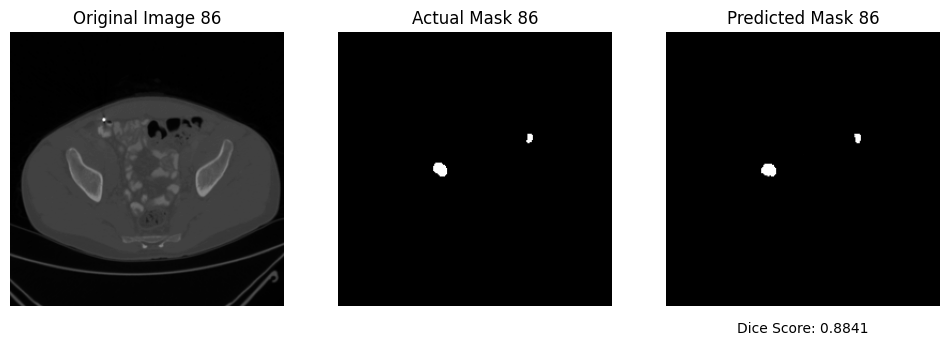

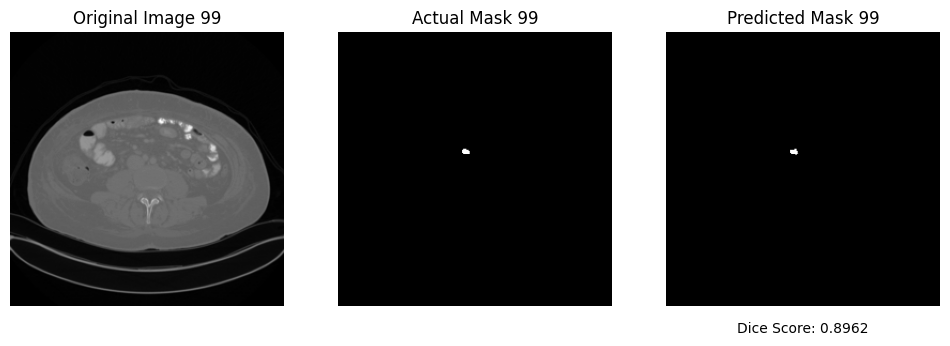

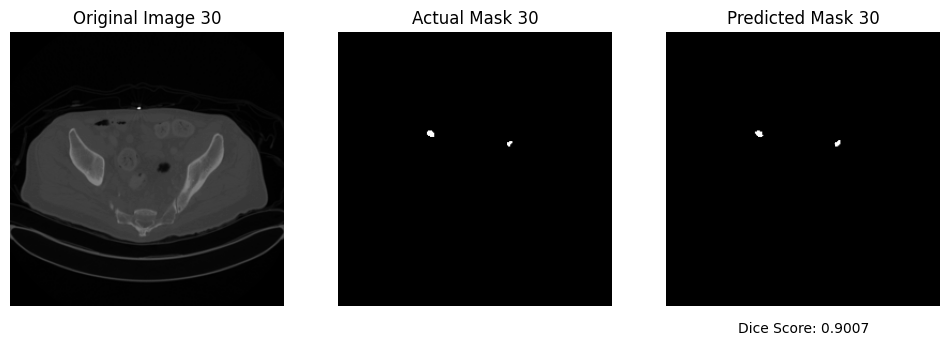

In [ ]:
# prompt: Test the model and show Image, actual and predicted mask

# Predict on the test set
predictions = model.predict(x_test)

# Display a few images, their actual masks, and the predicted masks
n_images_to_display = np.random.randint(0, len(x_test), 5)  # Adjust as needed

for i in n_images_to_display:
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray') # Remove channel dimension for display
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Actual Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title(f"Actual Mask {i+1}")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title(f"Predicted Mask {i+1}")
    plt.axis('off')

    # Calculate Dice score for the current image
    dice_score = dice_coefficient(y_test[i], predictions[i])
    # Note: dice_coefficient function should be defined as in your previous code

    # Display Dice score below the predicted mask
    plt.text(0.5, -0.1, f"Dice Score: {dice_score:.4f}", ha='center', transform=plt.gca().transAxes)

    plt.show()

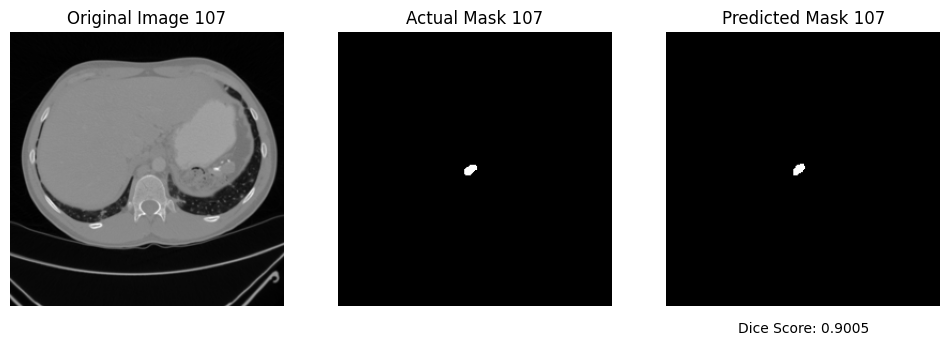

In [ ]:
# Display a few images, their actual masks, and the predicted masks
n_images_to_display = np.random.randint(0, len(x_test))  # Adjust as needed

i = n_images_to_display
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(x_test[i].squeeze(), cmap='gray') # Remove channel dimension for display
plt.title(f"Original Image {i+1}")
plt.axis('off')

# Actual Mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[i].squeeze(), cmap='gray')
plt.title(f"Actual Mask {i+1}")
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(predictions[i].squeeze(), cmap='gray')
plt.title(f"Predicted Mask {i+1}")
plt.axis('off')

# Calculate Dice score for the current image
dice_score = dice_coefficient(y_test[i], predictions[i])
# Note: dice_coefficient function should be defined as in your previous code

# Display Dice score below the predicted mask
plt.text(0.5, -0.1, f"Dice Score: {dice_score:.4f}", ha='center', transform=plt.gca().transAxes)

plt.show()